# Candy Defects Detection Report 2023

Prepared for: Deep Learning Classes 2023/24
Authors:
- [Wojciech Mączka - 148106](mailto:wojciech.maczka@student.put.poznan.pl)
- [Łukasz Andryszewski - 151930](mailto:lukasz.andryszewski@student.put.poznan.pl)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from tensorflow.keras.utils import plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler

from src.data import *
from src.plots import *
from src.models import *

2023-12-31 23:53:39.960074: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 23:53:39.993773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 23:53:39.993806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 23:53:39.994604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 23:53:39.999790: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 23:53:40.000682: I tensorflow/core/platform/cpu_feature_guard.cc:1

### The Task

 As a well-known data scientist, you were asked for help by a company producing candies. Some of their products are plagued with different types of defects. The whole manufacture is equipped with sensors so there are several time series describing the process of producing candies. They would like to achieve two goals:


1. Have a predictive model which will tell them if a given candy has a defect and which ones

2. Perform a root cause analysis - they would like to know what patterns in the data are related to defects



Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

### Data Description

- For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 
- One candy can have zero, one or more defects at once.
- Patterns are of different length
- There is one defect related to a pattern occurring at two sensors simultaneously



In [2]:
np.random.seed(42)
SAMPLES = 50000
DEVICE = 'cpu'
DEVICES = tf.config.list_logical_devices(DEVICE)
STRATEGY = tf.distribute.MirroredStrategy(DEVICES)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


[False False False  True False]


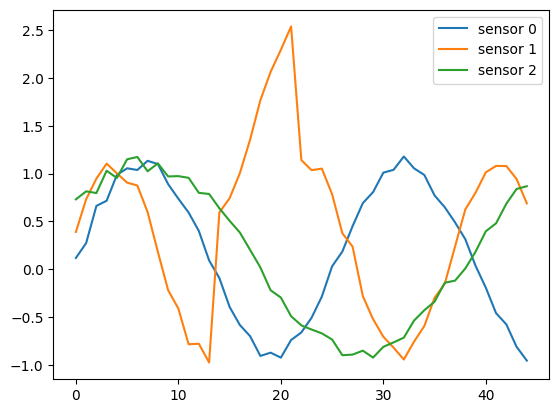

[False False False False False]


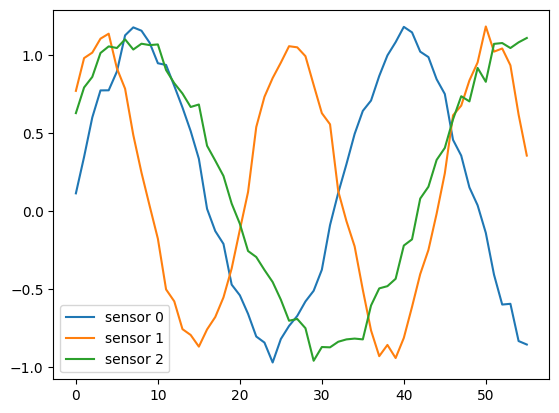

[False False False False  True]


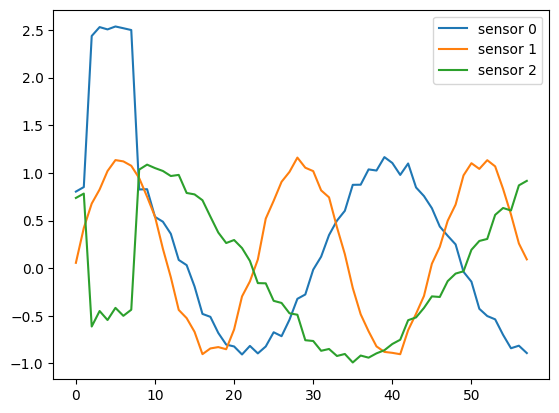

[ True False False False  True]


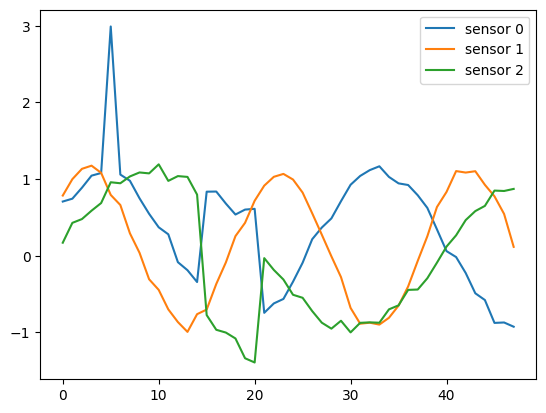

[False  True False False  True]


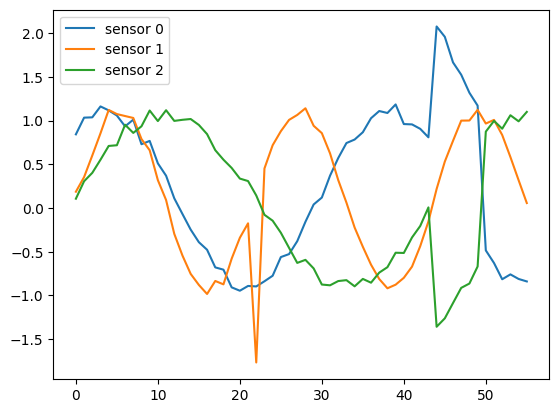

In [3]:
xl, yl = create_dataset(SAMPLES)
plot_sensors(xl,yl)

### Data Preprocessing

Data preprocessing steps:
- Padding with NaNs to the longest sequence length
- Scaling to the range [0,1] using MinMaxScaler from sci-kit learn library
- Converting NaNs to -2
- Splitting into train, validation and test sets using 80/10/10 ratio

In [4]:
x_pad = pad_sequences(xl, dtype='float64', value=np.nan)
y = np.array(yl).astype(np.uint8)

In [5]:
samples, timesteps, features = x_pad.shape
x_pad.shape

(50000, 59, 3)

In [6]:
_, labels = y.shape
y.shape

(50000, 5)

In [7]:
scaler = MinMaxScaler()
x_pad = scaler.fit_transform(x_pad.reshape(-1, x_pad.shape[-1])).reshape(x_pad.shape)
X = np.nan_to_num(x_pad,nan=-2)

In [8]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

N = len(x_pad)
train_size,val_size,test_size = int(N*train_frac),int(N*val_frac),int(N*test_frac)
data_idx = list(range(N))
np.random.shuffle(data_idx)
train_idx,test_idx,val_idx = data_idx[:train_size],data_idx[-test_size:],data_idx[train_size+1:train_size+val_size]
X_train,y_train = X[train_idx],y[train_idx]
X_test,y_test = X[test_idx],y[test_idx]
X_val,y_val = X[val_idx],y[val_idx]

### The Model

For the classification task, we decided to use a simple encoder architecture. The encoder consists of two GRU layers with 64 and 32 units respectively. The output of the last layer is passed to a ANN with 3 dense layers with 128, 32 and 5 units respectively, the last being the sigmoid layer. Additionally, after first and second dense layers, there is a dropout layer with dropout rate of 0.4 and a batch normalization layer. 

The model is trained using binary cross entropy loss and Adam optimizer with learning rate of 0.001. The model is trained for 30 epochs with early stopping and learning rate scheduler. The model is trained using MirroredStrategy to utilize multiple GPUs.

As a metric, we use binary accuracy. The model achieves 93% accuracy on the test set.

In [9]:
with STRATEGY.scope():
	adam = Adam(learning_rate=0.001)
	model = create_encoder(timesteps, features, labels)
	model.build(input_shape=(None,features))
	model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 gru (GRU)                   (None, 59, 64)            13248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                        

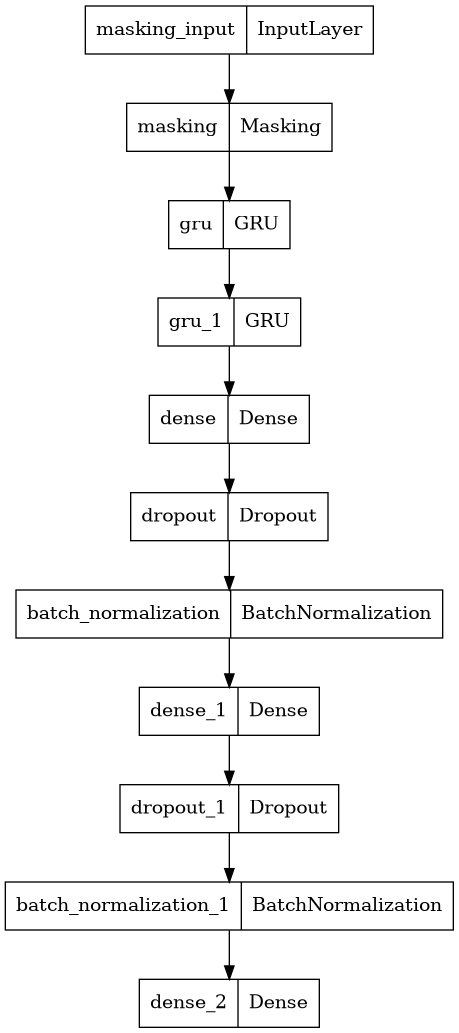

In [10]:
plot_model(model)

In [11]:
def learning_schedule(epoch,lr):
    return lr if epoch < 5 else lr * tf.math.exp(-0.1)

In [ ]:
early = EarlyStopping(patience=3, restore_best_weights=True)
scheduler = LearningRateScheduler(learning_schedule)
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), batch_size=64, epochs=30, callbacks=[early,scheduler])

Epoch 1/30


2023-12-31 23:53:51.440402: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 25s 32ms/step - loss: 0.5578 - binary_accuracy: 0.7178 - val_loss: 0.4317 - val_binary_accuracy: 0.8096 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 0.3880 - binary_accuracy: 0.8315

2023-12-31 23:54:33.582201: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.3880 - binary_accuracy: 0.8315 - val_loss: 0.4020 - val_binary_accuracy: 0.8141 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 18s 28ms/step - loss: 0.3310 - binary_accuracy: 0.8562 - val_loss: 0.4186 - val_binary_accuracy: 0.7772 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8825

2023-12-31 23:55:09.141880: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 28ms/step - loss: 0.2807 - binary_accuracy: 0.8825 - val_loss: 0.3813 - val_binary_accuracy: 0.8473 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 18s 29ms/step - loss: 0.2586 - binary_accuracy: 0.8916 - val_loss: 0.3051 - val_binary_accuracy: 0.8651 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - ETA: 0s - loss: 0.2333 - binary_accuracy: 0.9013

2023-12-31 23:55:45.523278: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 29ms/step - loss: 0.2333 - binary_accuracy: 0.9013 - val_loss: 0.2050 - val_binary_accuracy: 0.9104 - lr: 9.0484e-04
Epoch 7/30
625/625 [==============================] - 18s 29ms/step - loss: 0.2237 - binary_accuracy: 0.9044 - val_loss: 0.1948 - val_binary_accuracy: 0.9151 - lr: 8.1873e-04
Epoch 8/30
625/625 [==============================] - ETA: 0s - loss: 0.2010 - binary_accuracy: 0.9139

2023-12-31 23:56:21.276570: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 18s 28ms/step - loss: 0.2010 - binary_accuracy: 0.9139 - val_loss: 0.1722 - val_binary_accuracy: 0.9210 - lr: 7.4082e-04
Epoch 9/30
625/625 [==============================] - 18s 29ms/step - loss: 0.2004 - binary_accuracy: 0.9140 - val_loss: 0.2011 - val_binary_accuracy: 0.9103 - lr: 6.7032e-04
Epoch 10/30
268/625 [===========>..................] - ETA: 9s - loss: 0.1875 - binary_accuracy: 0.9198

In [ ]:
plot_history(history, metrics=['binary_accuracy'])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
y_pred

In [ ]:
y_thresh = (y_pred > 0.5).astype(np.uint8)
y_thresh

In [ ]:
y_test

In [ ]:
[accuracy_score(y_test[:,j],y_thresh[:,j]) for j in range(labels)]

### Root Cause Analysis

For the root cause analysis, we decided to use an autoencoder architecture. The autoencoder consists of two GRU layers with 64 and 32 units respectively, a Bottleneck layer with 5 units and two GRU layers with 32 and 64 units respectively. The output oof the last layer is passed to a time distributed dense layer with 3 units. The model is trained using mean absolute error loss and Adam optimizer with learning rate of 0.001. The model is trained for 5 epochs with early stopping and learning rate scheduler. The model is trained using MirroredStrategy to utilize multiple GPUs.

As a metric, we use mean squared error. The model achieves 0.005 MSE on the test set.

To explain the prediction, we divided our test set into normal samples and samples with defects (one of each type) and plotted the predictions of the autoencoder. We also created a threshold for each sensor based on the mean and standard deviation of the MSE loss of the normal samples. We then plotted the histogram of the MSE loss for each sensor for each type of defect. We can see that the MSE loss for normal samples is much lower than for samples with defects. We can also see that the MSE loss for samples with defects is higher than the threshold for the sensor that is related to the defect. This means that the autoencoder can detect the defects, and we can use the MSE loss to explain the prediction.

We marked the sensor that detected the defect.

In [ ]:
X_normal_train = X_train[y_train.any(axis=1) == False]
X_normal_val = X_val[y_val.any(axis=1) == False]

In [ ]:
with STRATEGY.scope():
	adam = Adam(learning_rate=0.001)
	autoencoder = create_autoencoder(timesteps, features, labels)
	autoencoder.build(input_shape=(None,features))
	autoencoder.compile(optimizer=adam, loss='mae', metrics=['mse'])

autoencoder.summary()

In [ ]:
plot_model(autoencoder)

In [ ]:
early = EarlyStopping(patience=2, restore_best_weights=True)
scheduler = LearningRateScheduler(lambda epoch,lr: lr if epoch < 5 else lr * tf.math.exp(-0.1))
history = autoencoder.fit(X_normal_train,X_normal_train, validation_data=[X_normal_val,X_normal_val], batch_size=32, epochs=5, callbacks=[ scheduler])

In [ ]:
plot_history(history, metrics=['mse'])

In [ ]:
X_pred = autoencoder.predict(X_test)

In [ ]:
autoencoder.evaluate(X_test,X_test)

In [ ]:
inputs = [X_test[(y_test.sum(axis=1) == 1) & (y_test[:, i] == 1)] for i in range(labels)]
outputs = [y_test[(y_test.sum(axis=1) == 1) & (y_test[:, i] == 1)] for i in range(labels)]
inputs.insert(0, X_test[y_test.any(axis=1) == False])
outputs.insert(0, y_test[y_test.any(axis=1) == False])

In [ ]:
for X, y in zip(inputs, outputs):
	X_pred, mask = get_autoencoder_predictions(autoencoder, X)
	plot_sensor_comparison(X_pred,X, y, mask, n=1)

In [ ]:
losses = get_error(autoencoder, inputs[0])
thresh = [np.mean(losses[i]) + 2 * np.std(losses[i]) for i in range(3)]
thresh

In [ ]:
for idx, X in enumerate(inputs):
	losses = get_error(autoencoder, X)
	
	if idx == 0:
		print('Normal samples')
	else:
		print(f'Defect of type {idx}')
	
	for i in range(3):
		print(f'Sensor {i+1}: {np.mean(losses[i])}', end='\t')
		if np.mean(losses[i]) > thresh[i]:
			print(f'Anomaly detected with sensor {i+1}')
		else:
			print()
	
	plt.hist(losses, bins=25)
	plt.xlabel('MSE loss')
	plt.ylabel('Number of samples')
	plt.legend(['Sensor 1', 'Sensor 2', 'Sensor 3'])
	plt.show()

### Results

We managed to create a classification model, which can accurately classify the type of defect for each sample of sensor data.

We also managed to create a pipeline to describe the prediction of the classification model. We can detect the type of defect and the sensor that detected the defect.
- Normal samples can be approximated with a sinusoidal function
- First type of defect is detected by sensor 1, as a single spike in the data
- Second type of defect is detected by sensor 2, as a single fall in the data
- Third type of defect is detected by sensor 3, as a local rise and plateau in the data
- Fourth type of defect is detected by sensor 2, as a local rise and plateau in the data
- Fifth type of defect is detected by sensors 1 and 3, as two different local rises/falls and plateaus in the data respectively

Our pipeline can be used to detect the type of defect and the sensor that detected the defect. This can be used to perform root cause analysis and fix the problem in the manufacturing process.